In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### plotting setup

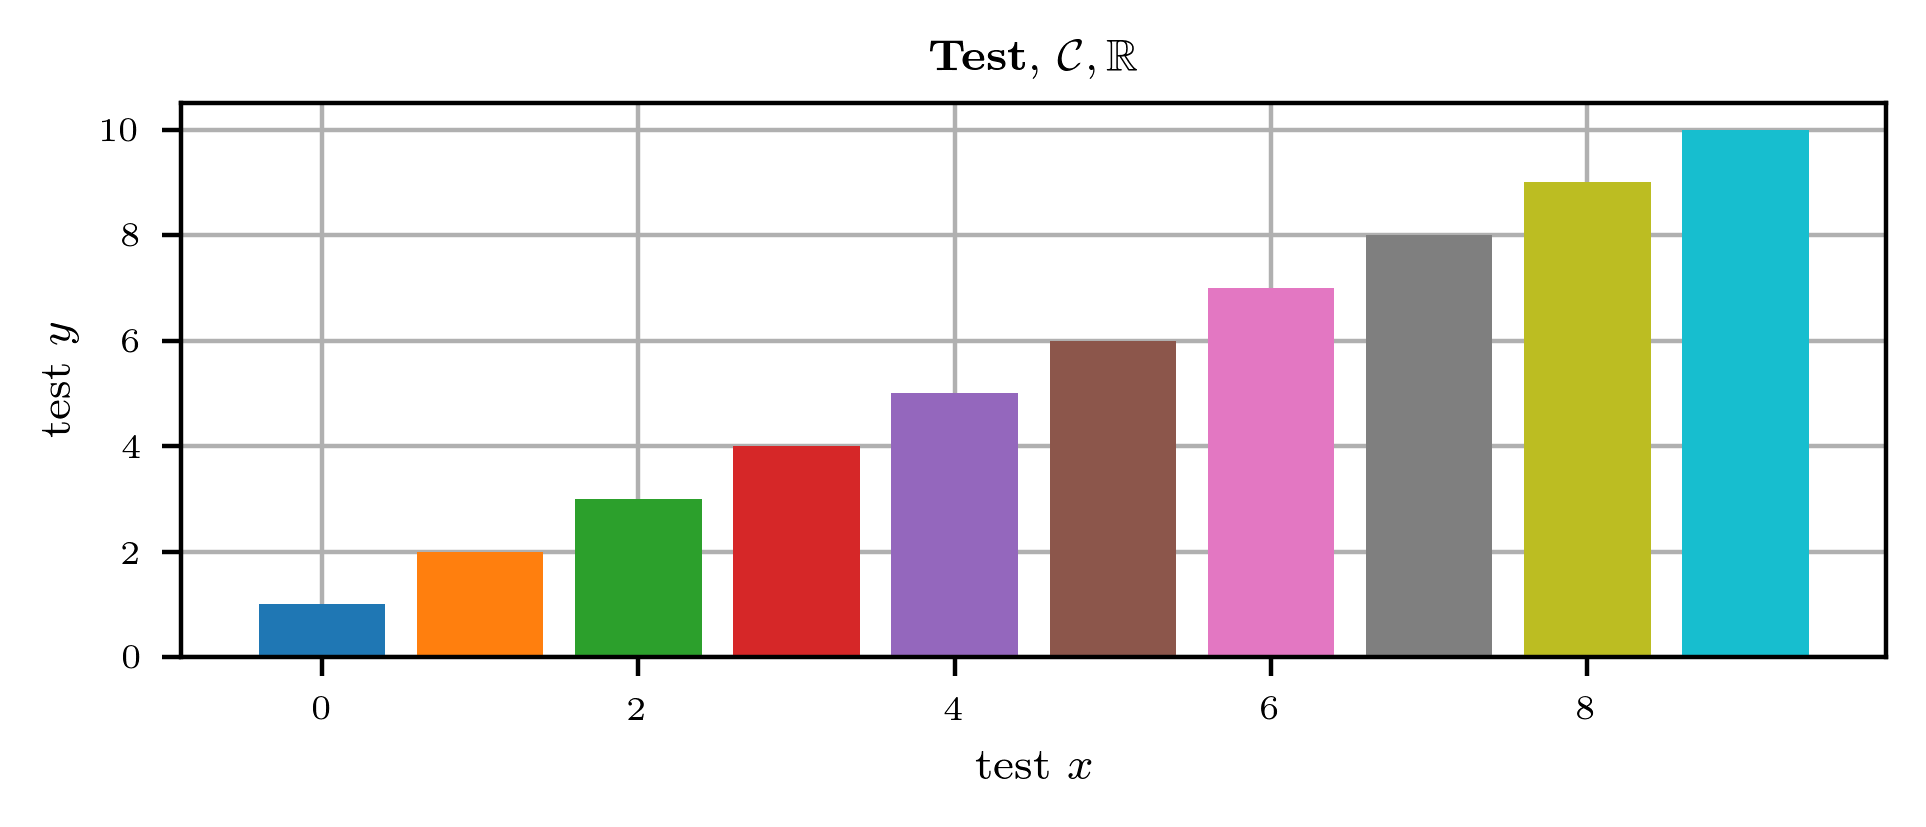

In [13]:
import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.50107  # in  --> Confirmed with template explanation

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  # figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})

# Test setup

plt.figure(dpi=400, figsize=(text_width, text_width/3))
plt.grid(0.3, zorder=0)
for i in range(10):
    plt.bar(i, i + 1, color=f'C{i}', zorder=2)
    # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
plt.title(r'\textbf{Test}, $\mathcal{C}, \mathbb{R}$')
plt.xlabel('test $x$')
plt.ylabel('test $y$')
plt.show()

# Define errorfill


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return


## package imports

In [14]:

import jax
from jax import jit, vmap
from jax import random
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scalable_gps
from scalable_gps import data
from scalable_gps.kernels import RBFKernel
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.models.sgd_gp_model import SGDGPModel
import optax

import ml_collections



## Generate Data

## ExactGP fits

In [44]:
from scalable_gps.kernels import Kernel
from scalable_gps.kernels import RBFKernel, Matern12Kernel, Matern32Kernel, Matern52Kernel


## 1d

In [51]:
n_features = 5000
num_samples = 20

key = jax.random.PRNGKey(0)
key_w, feature_key = jax.random.split(key)

kernel_config = {
    'signal_scale': jnp.array([1.]),
    'length_scale': jnp.array([0.5]),
}

kernel = Matern32Kernel(kernel_config=kernel_config)

params = kernel.feature_params(feature_key, n_features, 1)


x = jnp.linspace(0,1,1000)[:, None]
L = kernel.featurise(x, params)
w = jax.random.normal(key_w, shape=(n_features,num_samples))
f = L@w






Text(0.5, 1.0, 'lengthscale = [0.5]')

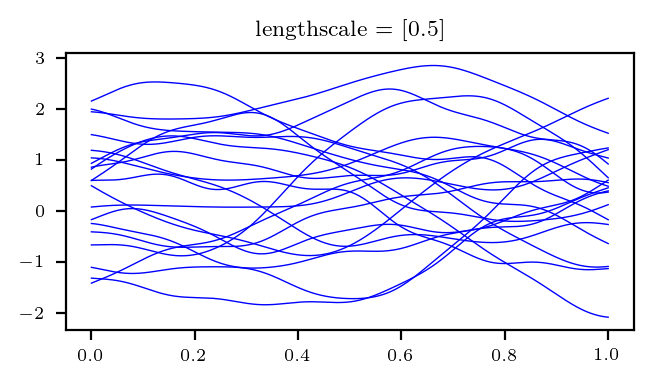

In [52]:
fig, ax = plt.subplots(1,1, figsize=(text_width/1.5,text_width/3), dpi=200)

_ = ax.plot(x, f, c='b', lw=0.5)
plt.title(f'lengthscale = {kernel_config["length_scale"]}')


## 2d

In [58]:
x = jnp.linspace(0,1,100)
y = jnp.linspace(0,1,100)

xv, yv = jnp.meshgrid(x, y)

point_list = jnp.stack([xv, yv], axis=-1)
point_list = point_list.reshape(-1, 2)


In [92]:
n_features = 5000
num_samples = 4

key = jax.random.PRNGKey(0)
key_w, feature_key = jax.random.split(key)

kernel_config = {
    'signal_scale': jnp.array([1.]),
    'length_scale': jnp.array([0.5]),
}

kernel = Matern32Kernel(kernel_config=kernel_config)

params = kernel.feature_params(feature_key, n_features, 2)


L = kernel.featurise(point_list, params)
w = jax.random.normal(key_w, shape=(n_features,num_samples))
f = L@w






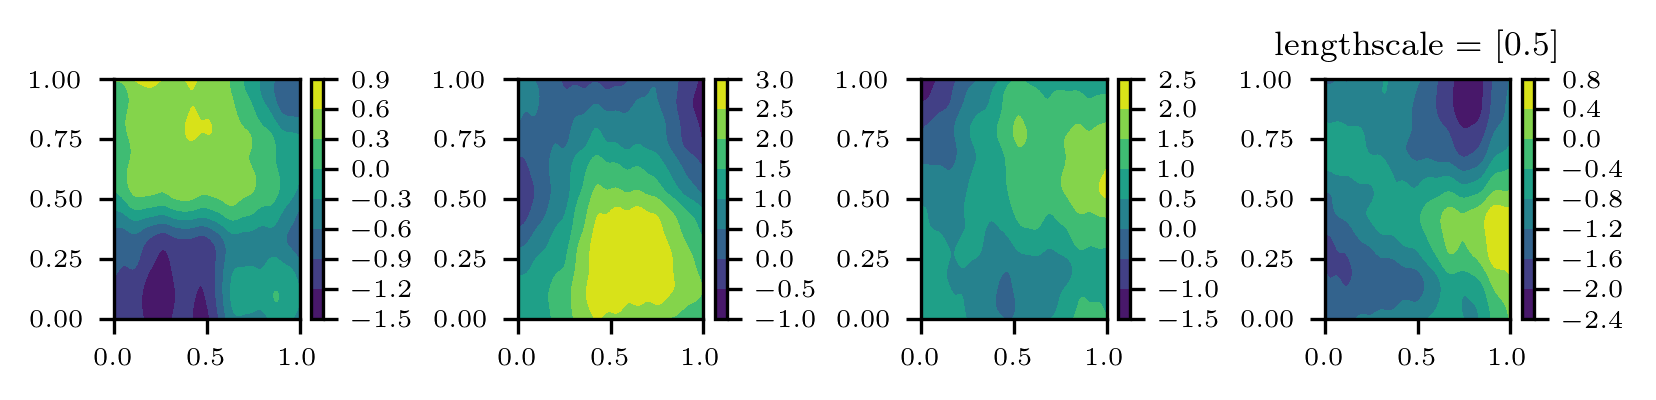

In [93]:
fig, ax = plt.subplots(1,num_samples, figsize=(text_width,text_width/4), dpi=300)

for i in range(num_samples):
    handle = ax[i].contourf(xv, yv, f[:,i].reshape(100,100))
    plt.title(f'lengthscale = {kernel_config["length_scale"]}')
    plt.colorbar(handle)
    
plt.tight_layout()


### view exact GP fits

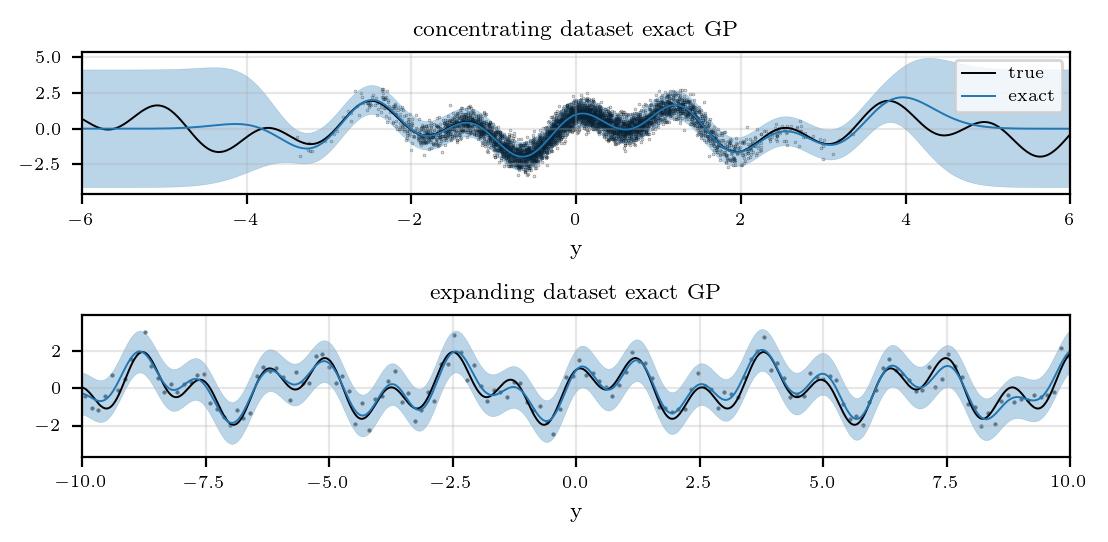

In [7]:
fig, ax = plt.subplots(2,1, figsize=(text_width,text_width/2), dpi=200)

ax[0].scatter(concentrate_data_train.x, concentrate_data_train.y,  0.05, alpha=0.5, c='k')
ax[0].plot(concentrate_data_test.x, concentrate_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(concentrate_data_test.x.squeeze(), concentrate_exact_pred_mean, 2*concentrate_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-6,6])
ax[0].legend()
ax[0].set_title('concentrating dataset exact GP')

ax[1].scatter(spread_data_train.x, spread_data_train.y,  0.3, alpha=0.5, c='k')
ax[1].plot(spread_data_test.x, spread_data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(spread_data_test.x.squeeze(), spread_exact_pred_mean, 2*spread_exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[1],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[1].set_xlabel('x')
ax[1].set_xlabel('y')
ax[1].grid(alpha=0.3)
ax[1].set_xlim([-10,10])
ax[1].set_title('expanding dataset exact GP')

plt.tight_layout()

# VI